# ORF recognition by Convolutional/Recurrent

So far CNN+GRU 64 overfits the 128 base RNA problem.
That was using 32K samples/class. Here, try more samples. 



In [1]:
import time 
t = time.time()
time.strftime('%Y-%m-%d %H:%M:%S %Z', time.localtime(t))

'2021-06-22 15:56:11 UTC'

In [2]:
PC_SEQUENCES=64000   # how many protein-coding sequences
NC_SEQUENCES=64000   # how many non-coding sequences
PC_TESTS=1000
NC_TESTS=1000
RNA_LEN=128            # how long is each sequence
CDS_LEN=64            # min CDS len to be coding
ALPHABET=4          # how many different letters are possible
INPUT_SHAPE_2D = (RNA_LEN,ALPHABET,1) # Conv2D needs 3D inputs
INPUT_SHAPE = (RNA_LEN,ALPHABET) # Conv1D needs 2D inputs
FILTERS = 64   # how many different patterns the model looks for
CELLS = 64
NEURONS = 64
DROP_RATE = 0.4
WIDTH = 3   # how wide each pattern is, in bases
STRIDE_2D = (1,1)  # For Conv2D how far in each direction
STRIDE = 1 # For Conv1D, how far between pattern matches, in bases
EPOCHS=100  # how many times to train on all the data
SPLITS=3  # SPLITS=3 means train on 2/3 and validate on 1/3 
FOLDS=3  # train the model this many times (range 1 to SPLITS)

In [3]:
import sys
IN_COLAB = False
try:
    from google.colab import drive
    IN_COLAB = True
except:
    pass
if IN_COLAB:
    print("On Google CoLab, mount cloud-local file, get our code from GitHub.")
    PATH='/content/drive/'
    #drive.mount(PATH,force_remount=True)  # hardly ever need this
    #drive.mount(PATH)    # Google will require login credentials
    DATAPATH=PATH+'My Drive/data/'  # must end in "/"
    import requests
    r = requests.get('https://raw.githubusercontent.com/ShepherdCode/Soars2021/master/SimTools/RNA_describe.py')
    with open('RNA_describe.py', 'w') as f:
        f.write(r.text)  
    from RNA_describe import ORF_counter
    from RNA_describe import Random_Base_Oracle
    r = requests.get('https://raw.githubusercontent.com/ShepherdCode/Soars2021/master/SimTools/RNA_prep.py')
    with open('RNA_prep.py', 'w') as f:
        f.write(r.text)  
    from RNA_prep import prepare_inputs_len_x_alphabet
else:
        print("CoLab not working. On my PC, use relative paths.")
        DATAPATH='data/'  # must end in "/"
        sys.path.append("..") # append parent dir in order to use sibling dirs
        from SimTools.RNA_describe import ORF_counter,Random_Base_Oracle
        from SimTools.RNA_prep import prepare_inputs_len_x_alphabet

MODELPATH="BestModel"  # saved on cloud instance and lost after logout
#MODELPATH=DATAPATH+MODELPATH  # saved on Google Drive but requires login


On Google CoLab, mount cloud-local file, get our code from GitHub.


In [4]:
from os import listdir
import csv
from zipfile import ZipFile

import numpy as np
import pandas as pd
from scipy import stats  # mode

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

from keras.models import Sequential
from keras.layers import Dense,Embedding,Dropout
from keras.layers import Conv1D,Conv2D
from keras.layers import GRU,LSTM
from keras.layers import Flatten,TimeDistributed
from keras.layers import MaxPooling1D,MaxPooling2D
from keras.losses import BinaryCrossentropy
# tf.keras.losses.BinaryCrossentropy

import matplotlib.pyplot as plt
from matplotlib import colors
mycmap = colors.ListedColormap(['red','blue'])  # list color for label 0 then 1
np.set_printoptions(precision=2)


In [5]:
rbo=Random_Base_Oracle(RNA_LEN,True)
pc_all,nc_all = rbo.get_partitioned_sequences(CDS_LEN,10) # just testing
pc_all,nc_all = rbo.get_partitioned_sequences(CDS_LEN,PC_SEQUENCES+PC_TESTS)
print("Use",len(pc_all),"PC seqs")
print("Use",len(nc_all),"NC seqs")

It took 20 trials to reach 10 per class.
It took 230481 trials to reach 65000 per class.
Use 65000 PC seqs
Use 65000 NC seqs


In [6]:
# Describe the sequences
def describe_sequences(list_of_seq):
    oc = ORF_counter()
    num_seq = len(list_of_seq)
    rna_lens = np.zeros(num_seq)
    orf_lens = np.zeros(num_seq)
    for i in range(0,num_seq):
        rna_len = len(list_of_seq[i])
        rna_lens[i] = rna_len
        oc.set_sequence(list_of_seq[i])
        orf_len = oc.get_max_orf_len()
        orf_lens[i] = orf_len
    print ("Average RNA length:",rna_lens.mean())
    print ("Average ORF length:",orf_lens.mean())
    
print("Simulated sequences prior to adjustment:")
print("PC seqs")
describe_sequences(pc_all)
print("NC seqs")
describe_sequences(nc_all)

Simulated sequences prior to adjustment:
PC seqs
Average RNA length: 128.0
Average ORF length: 79.07132307692308
NC seqs
Average RNA length: 128.0
Average ORF length: 27.53723076923077


In [7]:
pc_train=pc_all[:PC_SEQUENCES]
nc_train=nc_all[:NC_SEQUENCES]
pc_test=pc_all[PC_SEQUENCES:]
nc_test=nc_all[NC_SEQUENCES:]

In [8]:
# Use code from our SimTools library.
X,y = prepare_inputs_len_x_alphabet(pc_train,nc_train,ALPHABET) # shuffles
print("Data ready.")

Data ready.


In [9]:
def make_DNN():
    print("make_DNN")
    print("input shape:",INPUT_SHAPE)
    dnn = Sequential()
    #dnn.add(Embedding(input_dim=INPUT_SHAPE,output_dim=INPUT_SHAPE)) 
    dnn.add(Conv1D(filters=FILTERS,kernel_size=WIDTH,strides=STRIDE,padding="same",
            input_shape=INPUT_SHAPE))
    dnn.add(Conv1D(filters=FILTERS,kernel_size=WIDTH,strides=STRIDE,padding="same"))
    dnn.add(MaxPooling1D())
    #dnn.add(Conv1D(filters=FILTERS,kernel_size=WIDTH,strides=STRIDE,padding="same"))
    #dnn.add(Conv1D(filters=FILTERS,kernel_size=WIDTH,strides=STRIDE,padding="same"))
    #dnn.add(MaxPooling1D())
    #dnn.add(TimeDistributed(Flatten()))
    dnn.add(GRU(CELLS,return_sequences=True))
    dnn.add(GRU(CELLS,return_sequences=False))
    dnn.add(Dense(NEURONS,activation="sigmoid",dtype=np.float32))   
    dnn.add(Dropout(DROP_RATE))
    dnn.add(Dense(1,activation="sigmoid",dtype=np.float32))   
    dnn.compile(optimizer='adam',
                loss=BinaryCrossentropy(from_logits=False),
                metrics=['accuracy'])   # add to default metrics=loss
    dnn.build(input_shape=INPUT_SHAPE)   
    #ln_rate = tf.keras.optimizers.Adam(learning_rate = LN_RATE)
    #bc=tf.keras.losses.BinaryCrossentropy(from_logits=False)
    #model.compile(loss=bc, optimizer=ln_rate, metrics=["accuracy"])
    return dnn
model = make_DNN()
print(model.summary())

make_DNN
input shape: (128, 4)
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 128, 64)           832       
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 128, 64)           12352     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 64, 64)            0         
_________________________________________________________________
gru (GRU)                    (None, 64, 64)            24960     
_________________________________________________________________
gru_1 (GRU)                  (None, 64)                24960     
_________________________________________________________________
dense (Dense)                (None, 64)                4160      
_________________________________________________________________
dropout (Dropout)        

In [10]:
from keras.callbacks import ModelCheckpoint
def do_cross_validation(X,y):
    cv_scores = []
    fold=0
    mycallbacks = [ModelCheckpoint(
        filepath=MODELPATH, save_best_only=True, 
        monitor='val_accuracy', mode='max')]   
    splitter = KFold(n_splits=SPLITS)  # this does not shuffle
    for train_index,valid_index in splitter.split(X):
        if fold < FOLDS:
            fold += 1
            X_train=X[train_index] # inputs for training
            y_train=y[train_index] # labels for training
            X_valid=X[valid_index] # inputs for validation
            y_valid=y[valid_index] # labels for validation
            print("MODEL")
            # Call constructor on each CV. Else, continually improves the same model.
            model = model = make_DNN()
            print("FIT")  # model.fit() implements learning
            start_time=time.time()
            history=model.fit(X_train, y_train, 
                    epochs=EPOCHS, 
                    verbose=1,  # ascii art while learning
                    callbacks=mycallbacks,   # called at end of each epoch
                    validation_data=(X_valid,y_valid))
            end_time=time.time()
            elapsed_time=(end_time-start_time)                        
            print("Fold %d, %d epochs, %d sec"%(fold,EPOCHS,elapsed_time))
            # print(history.history.keys())  # all these keys will be shown in figure
            pd.DataFrame(history.history).plot(figsize=(8,5))
            plt.grid(True)
            plt.gca().set_ylim(0,1) # any losses > 1 will be off the scale
            plt.show()


MODEL
make_DNN
input shape: (128, 4)
FIT
Epoch 1/100
2667/2667 [==============================] - 56s 9ms/step - loss: 0.6974 - accuracy: 0.5332 - val_loss: 0.6252 - val_accuracy: 0.6456


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 2/100
2667/2667 [==============================] - 23s 9ms/step - loss: 0.6065 - accuracy: 0.6647 - val_loss: 0.5651 - val_accuracy: 0.6967


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 3/100
2667/2667 [==============================] - 23s 9ms/step - loss: 0.5636 - accuracy: 0.6974 - val_loss: 0.5667 - val_accuracy: 0.6950
Epoch 4/100
2667/2667 [==============================] - 23s 9ms/step - loss: 0.5537 - accuracy: 0.7041 - val_loss: 0.5605 - val_accuracy: 0.6987


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 5/100
2667/2667 [==============================] - 23s 9ms/step - loss: 0.5504 - accuracy: 0.7045 - val_loss: 0.5571 - val_accuracy: 0.7032


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 6/100
2667/2667 [==============================] - 23s 9ms/step - loss: 0.5430 - accuracy: 0.7107 - val_loss: 0.5564 - val_accuracy: 0.7050


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 7/100
2667/2667 [==============================] - 23s 9ms/step - loss: 0.5404 - accuracy: 0.7161 - val_loss: 0.5532 - val_accuracy: 0.7055


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 8/100
2667/2667 [==============================] - 23s 9ms/step - loss: 0.5375 - accuracy: 0.7167 - val_loss: 0.5519 - val_accuracy: 0.7017
Epoch 9/100
2667/2667 [==============================] - 23s 9ms/step - loss: 0.5309 - accuracy: 0.7187 - val_loss: 0.5544 - val_accuracy: 0.7009
Epoch 10/100
2667/2667 [==============================] - 23s 9ms/step - loss: 0.5277 - accuracy: 0.7222 - val_loss: 0.5489 - val_accuracy: 0.7081


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 11/100
2667/2667 [==============================] - 24s 9ms/step - loss: 0.5208 - accuracy: 0.7285 - val_loss: 0.5537 - val_accuracy: 0.7069
Epoch 12/100
2667/2667 [==============================] - 23s 9ms/step - loss: 0.5170 - accuracy: 0.7302 - val_loss: 0.5518 - val_accuracy: 0.7052
Epoch 13/100
2667/2667 [==============================] - 23s 9ms/step - loss: 0.5150 - accuracy: 0.7321 - val_loss: 0.5607 - val_accuracy: 0.7060
Epoch 14/100
2667/2667 [==============================] - 23s 9ms/step - loss: 0.5101 - accuracy: 0.7350 - val_loss: 0.5586 - val_accuracy: 0.7057
Epoch 15/100
2667/2667 [==============================] - 23s 9ms/step - loss: 0.5027 - accuracy: 0.7417 - val_loss: 0.5616 - val_accuracy: 0.7058
Epoch 16/100
2667/2667 [==============================] - 23s 9ms/step - loss: 0.4985 - accuracy: 0.7425 - val_loss: 0.5525 - val_accuracy: 0.7086


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 17/100
2667/2667 [==============================] - 23s 9ms/step - loss: 0.4917 - accuracy: 0.7475 - val_loss: 0.5612 - val_accuracy: 0.7104


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 18/100
2667/2667 [==============================] - 23s 9ms/step - loss: 0.4887 - accuracy: 0.7500 - val_loss: 0.5534 - val_accuracy: 0.7108


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 19/100
2667/2667 [==============================] - 23s 9ms/step - loss: 0.4875 - accuracy: 0.7502 - val_loss: 0.5418 - val_accuracy: 0.7140


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 20/100
2667/2667 [==============================] - 24s 9ms/step - loss: 0.4827 - accuracy: 0.7549 - val_loss: 0.5253 - val_accuracy: 0.7298


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 21/100
2667/2667 [==============================] - 24s 9ms/step - loss: 0.4964 - accuracy: 0.7487 - val_loss: 0.5474 - val_accuracy: 0.7156
Epoch 22/100
2667/2667 [==============================] - 23s 9ms/step - loss: 0.4985 - accuracy: 0.7512 - val_loss: 0.4673 - val_accuracy: 0.7776


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 23/100
2667/2667 [==============================] - 23s 9ms/step - loss: 0.4975 - accuracy: 0.7504 - val_loss: 0.6003 - val_accuracy: 0.6684
Epoch 24/100
2667/2667 [==============================] - 23s 9ms/step - loss: 0.5842 - accuracy: 0.6821 - val_loss: 0.5635 - val_accuracy: 0.6958
Epoch 25/100
2667/2667 [==============================] - 23s 9ms/step - loss: 0.5514 - accuracy: 0.7062 - val_loss: 0.4512 - val_accuracy: 0.7899


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 26/100
2667/2667 [==============================] - 23s 9ms/step - loss: 0.5351 - accuracy: 0.7228 - val_loss: 0.5367 - val_accuracy: 0.7249
Epoch 27/100
2667/2667 [==============================] - 23s 9ms/step - loss: 0.5262 - accuracy: 0.7297 - val_loss: 0.6037 - val_accuracy: 0.6685
Epoch 28/100
2667/2667 [==============================] - 23s 9ms/step - loss: 0.5878 - accuracy: 0.6833 - val_loss: 0.5662 - val_accuracy: 0.7001
Epoch 29/100
2667/2667 [==============================] - 23s 9ms/step - loss: 0.5834 - accuracy: 0.6849 - val_loss: 0.5814 - val_accuracy: 0.6862
Epoch 30/100
2667/2667 [==============================] - 23s 9ms/step - loss: 0.5729 - accuracy: 0.6914 - val_loss: 0.5867 - val_accuracy: 0.6774
Epoch 31/100
2667/2667 [==============================] - 23s 9ms/step - loss: 0.5689 - accuracy: 0.6923 - val_loss: 0.5552 - val_accuracy: 0.7010
Epoch 32/100
2667/2667 [==============================] - 23s 9ms/step - loss: 0.5649 - accuracy: 0.6989 - val_loss: 0

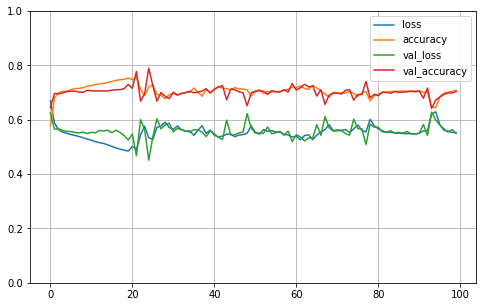

MODEL
make_DNN
input shape: (128, 4)
FIT
Epoch 1/100
2667/2667 [==============================] - 28s 9ms/step - loss: 0.6846 - accuracy: 0.5537 - val_loss: 0.5867 - val_accuracy: 0.6798
Epoch 2/100
2667/2667 [==============================] - 24s 9ms/step - loss: 0.5792 - accuracy: 0.6884 - val_loss: 0.5725 - val_accuracy: 0.6950
Epoch 3/100
2667/2667 [==============================] - 24s 9ms/step - loss: 0.5656 - accuracy: 0.6960 - val_loss: 0.5584 - val_accuracy: 0.7014
Epoch 4/100
2667/2667 [==============================] - 23s 9ms/step - loss: 0.5583 - accuracy: 0.7001 - val_loss: 0.5546 - val_accuracy: 0.7033
Epoch 5/100
2667/2667 [==============================] - 24s 9ms/step - loss: 0.5509 - accuracy: 0.7059 - val_loss: 0.5475 - val_accuracy: 0.7084
Epoch 6/100
2667/2667 [==============================] - 23s 9ms/step - loss: 0.5402 - accuracy: 0.7124 - val_loss: 0.5487 - val_accuracy: 0.7052
Epoch 7/100
2667/2667 [==============================] - 23s 9ms/step - loss: 0.534

INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 22/100
2667/2667 [==============================] - 24s 9ms/step - loss: 0.3776 - accuracy: 0.8126 - val_loss: 0.5417 - val_accuracy: 0.7256
Epoch 23/100
2667/2667 [==============================] - 23s 9ms/step - loss: 0.5589 - accuracy: 0.7032 - val_loss: 0.2798 - val_accuracy: 0.8746
Epoch 24/100
2667/2667 [==============================] - 24s 9ms/step - loss: 0.2385 - accuracy: 0.8908 - val_loss: 0.1812 - val_accuracy: 0.9138


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 25/100
2667/2667 [==============================] - 24s 9ms/step - loss: 0.3116 - accuracy: 0.8446 - val_loss: 0.1946 - val_accuracy: 0.9085
Epoch 26/100
2667/2667 [==============================] - 24s 9ms/step - loss: 0.1854 - accuracy: 0.9122 - val_loss: 0.6785 - val_accuracy: 0.5861
Epoch 27/100
2667/2667 [==============================] - 24s 9ms/step - loss: 0.6371 - accuracy: 0.6311 - val_loss: 0.5776 - val_accuracy: 0.6847
Epoch 28/100
2667/2667 [==============================] - 24s 9ms/step - loss: 0.5729 - accuracy: 0.6919 - val_loss: 0.4582 - val_accuracy: 0.7825
Epoch 29/100
2667/2667 [==============================] - 24s 9ms/step - loss: 0.5329 - accuracy: 0.7236 - val_loss: 0.6435 - val_accuracy: 0.6280
Epoch 30/100
2667/2667 [==============================] - 23s 9ms/step - loss: 0.5890 - accuracy: 0.6807 - val_loss: 0.4822 - val_accuracy: 0.7626
Epoch 31/100
2667/2667 [==============================] - 23s 9ms/step - loss: 0.3659 - accuracy: 0.8301 - val_loss: 0

INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 35/100
2667/2667 [==============================] - 23s 9ms/step - loss: 0.2487 - accuracy: 0.8771 - val_loss: 0.5197 - val_accuracy: 0.7332
Epoch 36/100
2667/2667 [==============================] - 24s 9ms/step - loss: 0.4781 - accuracy: 0.7611 - val_loss: 0.3613 - val_accuracy: 0.8364
Epoch 37/100
2667/2667 [==============================] - 24s 9ms/step - loss: 0.3774 - accuracy: 0.8222 - val_loss: 0.5284 - val_accuracy: 0.7264
Epoch 38/100
2667/2667 [==============================] - 24s 9ms/step - loss: 0.4858 - accuracy: 0.7545 - val_loss: 0.2680 - val_accuracy: 0.8757
Epoch 39/100
2667/2667 [==============================] - 24s 9ms/step - loss: 0.3823 - accuracy: 0.8192 - val_loss: 0.2037 - val_accuracy: 0.9048
Epoch 40/100
2667/2667 [==============================] - 24s 9ms/step - loss: 0.2174 - accuracy: 0.9011 - val_loss: 0.3440 - val_accuracy: 0.8380
Epoch 41/100
2667/2667 [==============================] - 24s 9ms/step - loss: 0.3550 - accuracy: 0.8289 - val_loss: 0

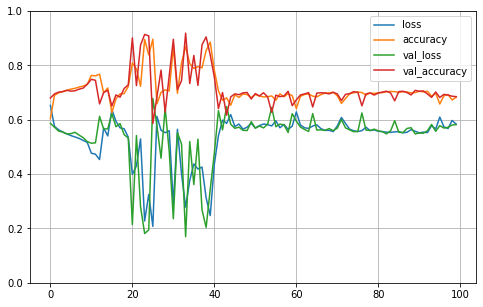

MODEL
make_DNN
input shape: (128, 4)
FIT
Epoch 1/100
2667/2667 [==============================] - 29s 10ms/step - loss: 0.6884 - accuracy: 0.5495 - val_loss: 0.6100 - val_accuracy: 0.6621
Epoch 2/100
2667/2667 [==============================] - 24s 9ms/step - loss: 0.5905 - accuracy: 0.6821 - val_loss: 0.5641 - val_accuracy: 0.6892
Epoch 3/100
2667/2667 [==============================] - 24s 9ms/step - loss: 0.5622 - accuracy: 0.6996 - val_loss: 0.5511 - val_accuracy: 0.7038
Epoch 4/100
2667/2667 [==============================] - 25s 9ms/step - loss: 0.5529 - accuracy: 0.7049 - val_loss: 0.5487 - val_accuracy: 0.7061
Epoch 5/100
2667/2667 [==============================] - 24s 9ms/step - loss: 0.5486 - accuracy: 0.7084 - val_loss: 0.5485 - val_accuracy: 0.7077
Epoch 6/100
2667/2667 [==============================] - 24s 9ms/step - loss: 0.5425 - accuracy: 0.7110 - val_loss: 0.5437 - val_accuracy: 0.7079
Epoch 7/100
2667/2667 [==============================] - 24s 9ms/step - loss: 0.53

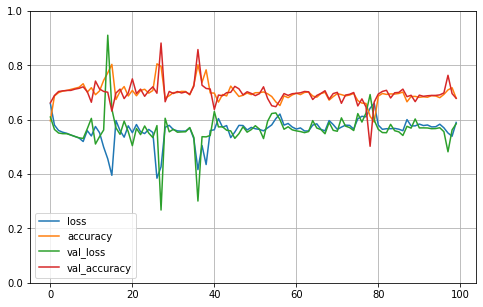

In [11]:
do_cross_validation(X,y)

In [12]:
from keras.models import load_model
X,y = prepare_inputs_len_x_alphabet(pc_test,nc_test,ALPHABET)
best_model=load_model(MODELPATH)
scores = best_model.evaluate(X, y, verbose=0)
print("The best model parameters were saved during cross-validation.")
print("Best was defined as maximum validation accuracy at end of any epoch.")
print("Now re-load the best model and test it on previously unseen data.")
print("Test on",len(pc_test),"PC seqs")
print("Test on",len(nc_test),"NC seqs")
print("%s: %.2f%%" % (best_model.metrics_names[1], scores[1]*100))


The best model parameters were saved during cross-validation.
Best was defined as maximum validation accuracy at end of any epoch.
Now re-load the best model and test it on previously unseen data.
Test on 1000 PC seqs
Test on 1000 NC seqs
accuracy: 92.85%


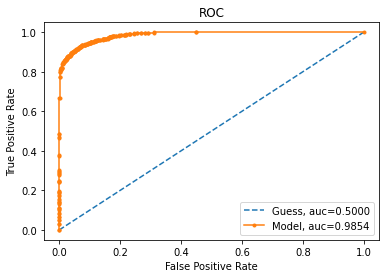

AUC: 98.54%


In [13]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
ns_probs = [0 for _ in range(len(y))]
bm_probs = best_model.predict(X)
ns_auc = roc_auc_score(y, ns_probs)
bm_auc = roc_auc_score(y, bm_probs)
ns_fpr, ns_tpr, _ = roc_curve(y, ns_probs)
bm_fpr, bm_tpr, _ = roc_curve(y, bm_probs)
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='Guess, auc=%.4f'%ns_auc)
plt.plot(bm_fpr, bm_tpr, marker='.', label='Model, auc=%.4f'%bm_auc)
plt.title('ROC')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()
print("%s: %.2f%%" %('AUC',bm_auc*100.0))


In [14]:
t = time.time()
time.strftime('%Y-%m-%d %H:%M:%S %Z', time.localtime(t))

'2021-06-22 18:00:12 UTC'